In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report, confusion_matrix, f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
actEnglish_11_df = pd.read_csv('../dataframes/actEnglish_11.csv')

In [3]:
actEnglish_11_df.head()

,studentId,is_proficient,proficient_score,course_ACT Review,course_ACT/WK Rev.,course_ACTReview.5C,course_AG Communica,course_AIDE-ELEM,course_AIDE-LIB,course_ALG I B ACCE,...,course_YearbkII9-12,course_Yearbook9-12,course_YrbkIII9-12,school_High School A,school_High School B,school_High School C,school_High School D,iready_math,iready_reading,bbb_literacy
0,45054,False,0.083333,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,0,0,0
1,45054,False,0.083333,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,0,0,0
2,45440,False,0.833333,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,0,0,0
3,45440,False,0.833333,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,0,0,0
4,45440,False,0.833333,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,0,0,0


PCA 

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Initialize scaler and scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(actEnglish_11_df.drop(['proficient_score', 'studentId', 'is_proficient'], axis=1))

# Perform PCA
pca = PCA()  # Initialize PCA without specifying components
pca.fit(X_scaled)

# Explained variance ratios
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_sum = 0
components = 0

for variance in explained_variance_ratio:
    cumulative_sum += variance
    components += 1
    if cumulative_sum >= 0.80:  # Adjust to your threshold (80%)
        break

print(f"Number of components needed: {components}")
print(f"Cumulative explained variance: {cumulative_sum}")


Number of components needed: 107
Cumulative explained variance: 0.800801047343418


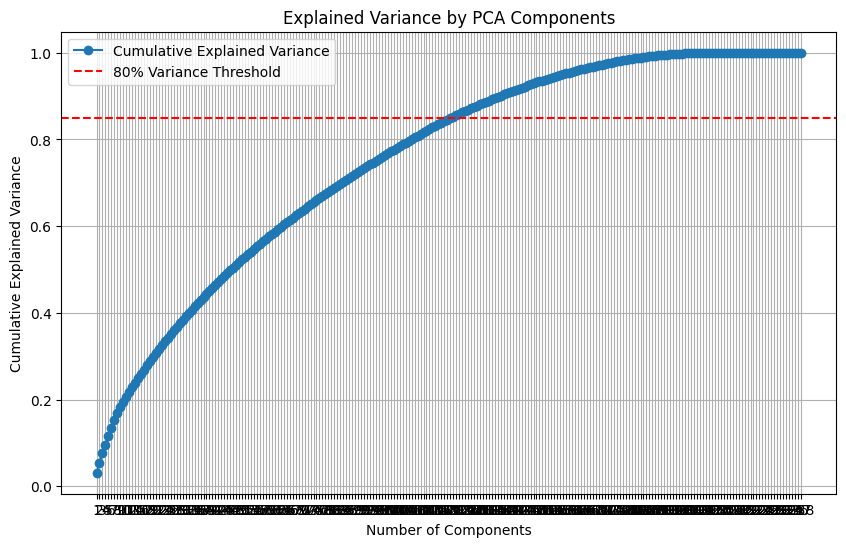

Number of components needed: 107


In [5]:
pca = PCA()  # Initialize PCA without specifying components
pca.fit(X_scaled)

# Explained variance ratios
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plotting the explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, marker='o', label='Cumulative Explained Variance')
plt.axhline(y=0.85, color='r', linestyle='--', label='80% Variance Threshold')
plt.title('Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.legend()
plt.grid()
plt.show()

# Calculate the number of components needed to explain at least 80% variance
components = np.argmax(cumulative_variance >= 0.80) + 1  # Add 1 to get the count of components
print(f"Number of components needed: {components}")

In [6]:
X_pca = pca.transform(X_scaled)
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
first_108_pcs_df = X_pca_df.iloc[:, :108].copy()
#first_108_pcs_df

In [7]:
print(pca.components_.shape)
print(actEnglish_11_df.columns)

cols_drop = ['studentId', 'is_proficient', 'proficient_score']
columns_to_drop = [col for col in cols_drop if col in actEnglish_11_df.columns]
feature_names = actEnglish_11_df.drop(columns=columns_to_drop).columns

(238, 238)
Index(['studentId', 'is_proficient', 'proficient_score', 'course_ACT Review',
       'course_ACT/WK Rev.', 'course_ACTReview.5C', 'course_AG Communica',
       'course_AIDE-ELEM', 'course_AIDE-LIB', 'course_ALG I B ACCE',
       ...
       'course_YearbkII9-12', 'course_Yearbook9-12', 'course_YrbkIII9-12',
       'school_High School A', 'school_High School B', 'school_High School C',
       'school_High School D', 'iready_math', 'iready_reading',
       'bbb_literacy'],
      dtype='object', length=241)


In [8]:
components = pca.components_[:108]  
# Create a DataFrame for feature loadings
# Rows correspond to features, and columns correspond to principal components
feature_loadings_df = pd.DataFrame(
    components.T,  # Transpose to match features as rows
    columns=[f'PC{i+1}' for i in range(components.shape[0])],  # PC1, PC2, ..., PC108
    index= feature_names  # Feature names
)

# Initialize a list to store the top features across all principal components
all_top_features = []

# For each principal component, find the top features
for pc in feature_loadings_df.columns:
    # Get the absolute values of the loadings and sort them
    sorted_features = feature_loadings_df[pc].abs().sort_values(ascending=False)
    # Get the top 5 features for the current principal component (adjustable)
    top_features = sorted_features.head(5).index.tolist()
    # Add the component and its top features to the list
    for feature in top_features:
        all_top_features.append((pc, feature))

# Create a DataFrame to view all top features for each principal component
top_features_df = pd.DataFrame(all_top_features, columns=['Principal Component', 'Top Feature'])

# Display the DataFrame
print(top_features_df)

    Principal Component           Top Feature
0                   PC1    course_HEALTH 9-12
1                   PC1     course_DRIVERS ED
2                   PC1  school_High School B
3                   PC1    course_D&TSafetyEd
4                   PC1    course_Health 9-12
..                  ...                   ...
535               PC108     course_Accounting
536               PC108   course_Food Nutritn
537               PC108   course_AlgEnrichmet
538               PC108    course_MARKET PRIN
539               PC108      course_Vocal I 1

[540 rows x 2 columns]


In [9]:
top_features_df.head(15)

,Principal Component,Top Feature
0,PC1,course_HEALTH 9-12
1,PC1,course_DRIVERS ED
2,PC1,school_High School B
3,PC1,course_D&TSafetyEd
4,PC1,course_Health 9-12
5,PC2,course_Physical Sci
6,PC2,course_English Gr10
7,PC2,course_Algebra I B
8,PC2,course_USHis I G10
9,PC2,course_US His-1877


In [10]:
# Find the most positively and negatively correlated features with each principal component
positive_correlations = {}
negative_correlations = {}

# Iterate through the loadings for each component
for pc in feature_loadings_df.columns:
    # Get the features with positive correlations (largest positive values)
    positive_features = feature_loadings_df[pc][feature_loadings_df[pc] > 0].sort_values(ascending=False)
    negative_features = feature_loadings_df[pc][feature_loadings_df[pc] < 0].sort_values(ascending=True)
    
    # Store the positive and negative correlations
    positive_correlations[pc] = positive_features
    negative_correlations[pc] = negative_features

# Print the results
print("Positive Correlations:")
for pc, features in positive_correlations.items():
    print(f"{pc}: {features.head()}")  # Display top 5 positively correlated features

print("\nNegative Correlations:")
for pc, features in negative_correlations.items():
    print(f"{pc}: {features.head()}")  # Display top 5 negatively correlated features


Positive Correlations:
PC1: course_HEALTH 9-12      0.265033
course_DRIVERS ED       0.264274
school_High School B    0.239028
course_BullBogAdv       0.216370
course_HS US 10 ADV     0.188087
Name: PC1, dtype: float64
PC2: course_Physical Sci    0.381306
course_English Gr10    0.369983
course_Algebra I B     0.333900
course_USHis I G10     0.242009
course_US His-1877     0.233797
Name: PC2, dtype: float64
PC3: course_Eng Gr10 Adv    0.280539
course_ChemistryAdv    0.273926
course_USHis I Adv     0.216134
course_HS US 10 ADV    0.211937
course_D&TSafetyEd     0.201282
Name: PC3, dtype: float64
PC4: course_Ess II:USHis    0.371516
course_Ess: Phy Sci    0.348738
course_Eng Ess 10      0.347513
course_Alg Esntls B    0.331559
course_RdIntrv7-12     0.235541
Name: PC4, dtype: float64
PC5: course_Eng Gr10 Adv     0.223295
course_ChemistryAdv     0.221125
course_USHis I Adv      0.210822
course_Panther Adv      0.208484
school_High School A    0.208484
Name: PC5, dtype: float64
PC6: course_

In [11]:
import pandas as pd

# Assuming `components` are PCA components and `feature_names` is your list of feature names

# Creating a DataFrame for feature loadings
feature_loadings_df = pd.DataFrame(
    components.T,  # Transpose to match features as rows
    columns=[f'PC{i+1}' for i in range(components.shape[0])],  # PC1, PC2, ..., PC108
    index=feature_names  # Feature names
)

# Initialize dictionaries to store positive and negative correlations
positive_correlations = {}
negative_correlations = {}

# Iterate through the loadings for each component
for pc in feature_loadings_df.columns:
    # Get the features with positive correlations (largest positive values)
    positive_features = feature_loadings_df[pc][feature_loadings_df[pc] > 0].sort_values(ascending=False)
    negative_features = feature_loadings_df[pc][feature_loadings_df[pc] < 0].sort_values(ascending=True)
    
    # Store the positive and negative correlations
    positive_correlations[pc] = positive_features
    negative_correlations[pc] = negative_features

# Display Positive Correlations
print("Positive Correlations:")
for pc, features in positive_correlations.items():
    print(f"{pc}: {features.head()}")  # Display top 5 positively correlated features

# Display Negative Correlations
print("\nNegative Correlations:")
for pc, features in negative_correlations.items():
    print(f"{pc}: {features.head()}")  # Display top 5 negatively correlated features

# Optionally, if you want to display them as a DataFrame for easier viewing
positive_df = pd.DataFrame(positive_correlations).fillna("")
negative_df = pd.DataFrame(negative_correlations).fillna("")

# Display the DataFrames
print("\nPositive Correlations DataFrame:")
print(positive_df)

print("\nNegative Correlations DataFrame:")
print(negative_df)


Positive Correlations:
PC1: course_HEALTH 9-12      0.265033
course_DRIVERS ED       0.264274
school_High School B    0.239028
course_BullBogAdv       0.216370
course_HS US 10 ADV     0.188087
Name: PC1, dtype: float64
PC2: course_Physical Sci    0.381306
course_English Gr10    0.369983
course_Algebra I B     0.333900
course_USHis I G10     0.242009
course_US His-1877     0.233797
Name: PC2, dtype: float64
PC3: course_Eng Gr10 Adv    0.280539
course_ChemistryAdv    0.273926
course_USHis I Adv     0.216134
course_HS US 10 ADV    0.211937
course_D&TSafetyEd     0.201282
Name: PC3, dtype: float64
PC4: course_Ess II:USHis    0.371516
course_Ess: Phy Sci    0.348738
course_Eng Ess 10      0.347513
course_Alg Esntls B    0.331559
course_RdIntrv7-12     0.235541
Name: PC4, dtype: float64
PC5: course_Eng Gr10 Adv     0.223295
course_ChemistryAdv     0.221125
course_USHis I Adv      0.210822
course_Panther Adv      0.208484
school_High School A    0.208484
Name: PC5, dtype: float64
PC6: course_

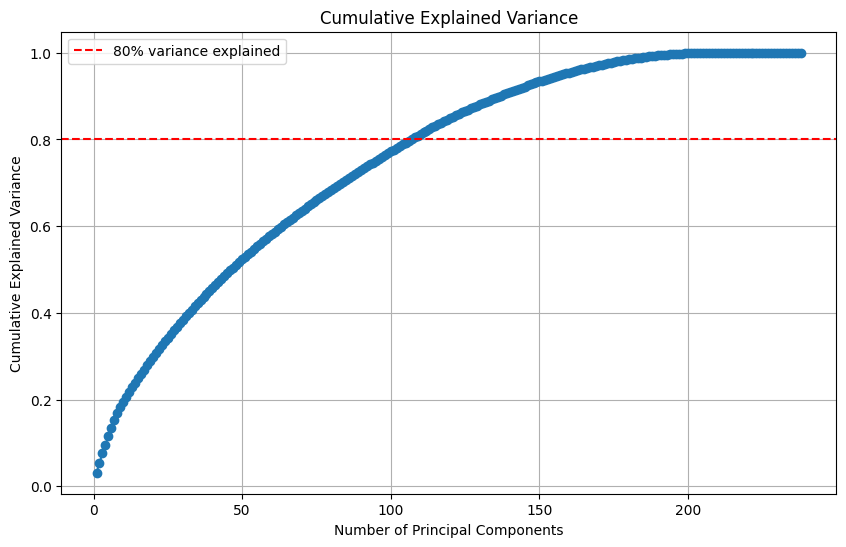

In [12]:
# Cumulative Explained Variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.axhline(y=0.80, color='r', linestyle='--', label='80% variance explained')  # Adjust threshold as needed
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.grid(True)
plt.show()

Training on PCA columns

In [13]:
X = first_108_pcs_df  # PCA-transformed features
y = actEnglish_11_df['proficient_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)
print(X_train.shape)

(2064, 108)


In [14]:
#possible hyperparameters
'''
max_depth_values= [8,12,25,32]
min_samples_leaf_values = [4,5,8,10]
param_grid = {'max_depth' : list(max_depth_values), 'min_samples_leaf' : list(min_samples_leaf_values)}


#Grid Search to find the best hyperparameters 
print("Running Grid Search")
dt_regressor = DecisionTreeRegressor()

# will have a 3-fold cross validation 
dt_grid = GridSearchCV(dt_regressor, param_grid, cv=3, scoring='neg_root_mean_squared_error')
dt_grid_search = dt_grid.fit(X_train, y_train)

print("Done")
dt_best_params = dt_grid_search.best_params_

dt_best_params
'''
#{'max_depth': 32, 'min_samples_leaf': 4}

'\nmax_depth_values= [8,12,25,32]\nmin_samples_leaf_values = [4,5,8,10]\nparam_grid = {\'max_depth\' : list(max_depth_values), \'min_samples_leaf\' : list(min_samples_leaf_values)}\n\n\n#Grid Search to find the best hyperparameters \nprint("Running Grid Search")\ndt_regressor = DecisionTreeRegressor()\n\n# will have a 3-fold cross validation \ndt_grid = GridSearchCV(dt_regressor, param_grid, cv=3, scoring=\'neg_root_mean_squared_error\')\ndt_grid_search = dt_grid.fit(X_train, y_train)\n\nprint("Done")\ndt_best_params = dt_grid_search.best_params_\n\ndt_best_params\n'

In [15]:
dt_model = DecisionTreeRegressor(max_depth=32, min_samples_leaf=4)
dt_model.fit(X_train,y_train)

#testing model on the X_test
y_dt_pred = dt_model.predict(X_test)
dt_rmse = mean_squared_error(y_test,y_dt_pred,squared=False)
dt_r2 = r2_score(y_test,y_dt_pred)

#trying to get f1 and accuracy score 
threshold = 1
y_pred_bool = y_dt_pred >= threshold
y_test_bool = y_test >= threshold

print("threshold=", threshold)
# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test_bool, y_pred_bool))

print('[DT] Root Mean Squared Error: {0}'.format(dt_rmse))
print('[DT] R2: {0}'.format(dt_r2))

#extracting from classification report for bar graph
report = classification_report(y_test_bool, y_pred_bool, output_dict=True)

# Extract accuracy from the report dictionary
accuracy = report['accuracy']

# Extract other metrics you want to plot, like precision and recall for the "True" class
precision_true = report['True']['precision']
recall_true = report['True']['recall']



threshold= 1

Classification Report:
              precision    recall  f1-score   support

       False       0.75      0.95      0.84       331
        True       0.85      0.44      0.58       185

    accuracy                           0.77       516
   macro avg       0.80      0.70      0.71       516
weighted avg       0.79      0.77      0.75       516

[DT] Root Mean Squared Error: 0.23933565074271584
[DT] R2: 0.4421610707823106


c:\Users\lmmag\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [16]:
micro_f1 = f1_score(y_test_bool, y_pred_bool, average='micro')

print("Micro F1 Score:", micro_f1)

Micro F1 Score: 0.7713178294573644


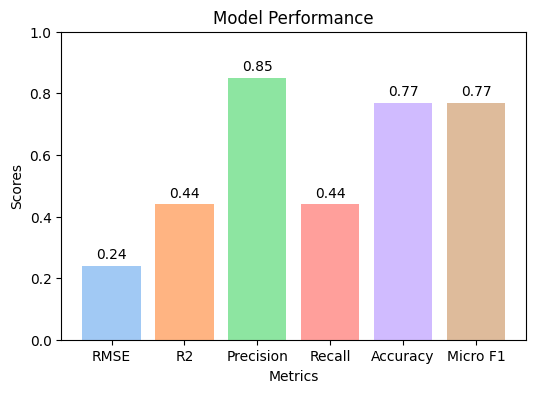

In [17]:
metrics = ['RMSE', 'R2', 'Precision', 'Recall', 'Accuracy', 'Micro F1']
values = [dt_rmse,dt_r2,precision_true,recall_true,accuracy,micro_f1]

rounded_values = [round(value, 2) for value in values]

# Get a pastel color palette
pastel_colors = sns.color_palette("pastel", len(metrics))

# Plot the bar chart with pastel colors
fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(metrics, rounded_values, color=pastel_colors)

# Add labels directly on top of bars
ax.bar_label(bars, padding=3, fontsize=10)  # padding adds space between bar and label
ax.set_ylim(0, 1)  # This will ensure the y-axis goes from 0 to 1

# Add labels and title
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Model Performance')

# Display the plot
plt.show()


Training no/PCA

In [18]:
print(actEnglish_11_df.dtypes)

studentId                 int64
is_proficient              bool
proficient_score        float64
course_ACT Review          bool
course_ACT/WK Rev.         bool
                         ...   
school_High School C       bool
school_High School D       bool
iready_math               int64
iready_reading            int64
bbb_literacy              int64
Length: 241, dtype: object


In [19]:
#changing all bools to ints 0 and 1 for the model
actEnglish_11_df[actEnglish_11_df.select_dtypes(include=['bool']).columns] = actEnglish_11_df.select_dtypes(include=['bool']).astype(int)
actEnglish_11_df.dtypes

studentId                 int64
is_proficient             int64
proficient_score        float64
course_ACT Review         int64
course_ACT/WK Rev.        int64
                         ...   
school_High School C      int64
school_High School D      int64
iready_math               int64
iready_reading            int64
bbb_literacy              int64
Length: 241, dtype: object

In [20]:
#Create Training and Test Data
y_English = actEnglish_11_df['proficient_score']
X_English= actEnglish_11_df.drop(['proficient_score','is_proficient', 'studentId'], axis=1)
print("Number of examples: " + str(X_English.shape[0]))

X_train_English,X_test_English, y_train_English,y_test_English  = train_test_split(X_English,y_English, test_size=0.20,stratify = actEnglish_11_df['is_proficient'],random_state=123)
print(X_train_English.shape)
print(X_test_English.shape)

#possible hyperparameters
max_depth_values_English = [8,12,25,32]
min_samples_leaf_values_English = [4,5,8,10]
param_grid_English = {'max_depth' : list(max_depth_values_English), 'min_samples_leaf' : list(min_samples_leaf_values_English)}

Number of examples: 2580
(2064, 238)
(516, 238)


In [21]:
#Grid Search to find the best hyperparameters 
'''
print("Running Grid Search")
dt_regressor_English= DecisionTreeRegressor()

# will have a 3-fold cross validation 
dt_grid_English= GridSearchCV(dt_regressor_English, param_grid_English, cv=3, scoring='neg_root_mean_squared_error')
dt_grid_search_English = dt_grid_English.fit(X_train_English, y_train_English)

print("Done")
dt_best_params_English = dt_grid_search_English.best_params_

dt_best_params_English
'''
#{'max_depth': 32, 'min_samples_leaf': 5}

'\nprint("Running Grid Search")\ndt_regressor_English= DecisionTreeRegressor()\n\n# will have a 3-fold cross validation \ndt_grid_English= GridSearchCV(dt_regressor_English, param_grid_English, cv=3, scoring=\'neg_root_mean_squared_error\')\ndt_grid_search_English = dt_grid_English.fit(X_train_English, y_train_English)\n\nprint("Done")\ndt_best_params_English = dt_grid_search_English.best_params_\n\ndt_best_params_English\n'

In [22]:
dt_model_English = DecisionTreeRegressor(max_depth=32, min_samples_leaf=5)
dt_model_English.fit(X_train_English,y_train_English)

#testing model on the X_test
y_dt_pred_English = dt_model_English.predict(X_test_English)
dt_rmse_English = mean_squared_error(y_test_English,y_dt_pred_English,squared=False)
dt_r2_English = r2_score(y_test_English,y_dt_pred_English)

#trying to get f1 and accuracy score 
threshold = 1
y_pred_English_bool = y_dt_pred_English >= threshold
y_test_English_bool = y_test_English >= threshold

print("threshold=", threshold)
# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test_English_bool, y_pred_English_bool))

print('[DT] Root Mean Squared Error: {0}'.format(dt_rmse_English))
print('[DT] R2: {0}'.format(dt_r2_English))

threshold= 1

Classification Report:
              precision    recall  f1-score   support

       False       0.78      0.93      0.85       349
        True       0.76      0.44      0.56       167

    accuracy                           0.77       516
   macro avg       0.77      0.69      0.70       516
weighted avg       0.77      0.77      0.75       516

[DT] Root Mean Squared Error: 0.2534251038889202
[DT] R2: 0.38100109453121944


c:\Users\lmmag\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [23]:
micro_f1_2 = f1_score(y_test_English_bool, y_pred_English_bool, average='micro')

print("Micro F1 Score:", micro_f1_2)

Micro F1 Score: 0.7732558139534884


Feature importance

In [24]:
importances = dt_model_English.feature_importances_
feature_names = X_train_English.columns

# Combine names and importances, and sort
importance_df_English = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df_English= importance_df_English.sort_values(by='Importance', ascending=False)

# Display the sorted DataFrame
print(importance_df_English)

                  Feature  Importance
58    course_ChemistryAdv    0.437092
84      course_Enviro Sci    0.045409
29     course_Algebra I B    0.041809
76    course_Eng Gr10 Adv    0.029090
23    course_Alg Esntls B    0.027047
..                    ...         ...
226   course_WH1500-P Adv    0.000000
225   course_WH 1500-P-CR    0.000000
231  school_High School A    0.000000
230    course_YrbkIII9-12    0.000000
237          bbb_literacy    0.000000

[238 rows x 2 columns]


In [25]:
importance_df_English.head(10)

,Feature,Importance
58,course_ChemistryAdv,0.437092
84,course_Enviro Sci,0.045409
29,course_Algebra I B,0.041809
76,course_Eng Gr10 Adv,0.029090
23,course_Alg Esntls B,0.027047
40,course_BandConcer.5,0.022717
156,course_Phy Sci Adv,0.020530
234,school_High School D,0.020067
111,course_HISTUS1877AC,0.018607
113,course_Health 9-12,0.015970


In [26]:
import shap

c:\Users\lmmag\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
explainer = shap.Explainer(dt_model_English)
shap_test = explainer(X_test_English)
shap_df = pd.DataFrame(shap_test.values, columns=shap_test.feature_names,
  index=X_test_English.index)
# Fetch the importances
shap_df = shap_df.apply(np.abs).mean().sort_values(ascending=False)
print(shap_df)

course_ChemistryAdv     0.088521
course_Algebra I B      0.043825
course_Eng Gr10 Adv     0.014079
course_Enviro Sci       0.010905
course_US His-1877      0.010151
                          ...   
course_WH1500-P Adv     0.000000
course_WH 1500-P-CR     0.000000
school_High School A    0.000000
course_YrbkIII9-12      0.000000
bbb_literacy            0.000000
Length: 238, dtype: float64


<Axes: title={'center': 'Top 10 Important Features'}>

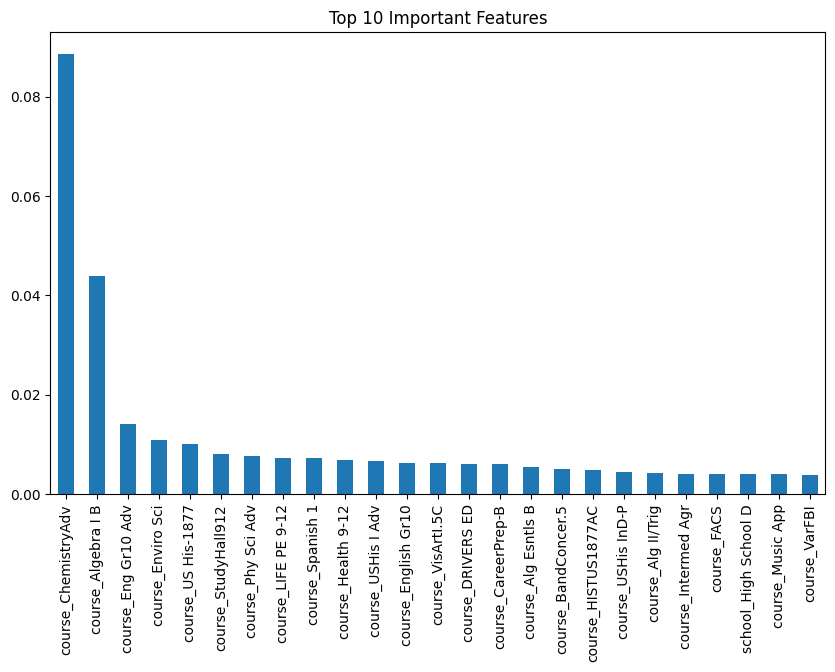

In [28]:
shap_df.head(25).plot(kind='bar', title='Top 10 Important Features', figsize=(10, 6))
